Populating the interactive namespace from numpy and matplotlib
read table m17+cdpp+gaia2+ber20 from ckscool/../cache/load_table_cache.hdf
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 39
    # variables        = 3
    chi-square         = 4.19485649
    reduced chi-square = 0.11652379
    Akaike info crit   = -80.9583982
    Bayesian info crit = -75.9677132
[[Variables]]
    a:  26.0932380 +/- 1.15465804 (4.43%) (init = 30)
    b:  0.31960918 +/- 0.01468851 (4.60%) (init = 0.27)
    c:  0.94060189 +/- 0.00596692 (0.63%) (init = 0.94)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.997
    C(b, c) =  0.542
    C(a, c) = -0.507


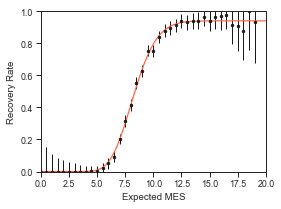

In [8]:
from astropy.io import ascii
import ckscool.io
import scipy.stats
import ckscool.comp
import pandas as pd
import seaborn as sns
import lmfit

%pylab inline

df = ascii.read('kplr_dr25_inj1_plti.txt')
df = df.to_pandas().rename(columns={'KIC_ID':'id_kic'})
field = ckscool.io.load_table('field-cuts')
field = field[~field.isany]
df = pd.merge(field[['id_kic']],df)
df = df[df.Recovered.isin([0,1])] # a few have values of 2 for some reason

binw = 0.5
snrbins = arange(0,20,binw)
snrbinc = snrbins[:-1]
df['Recovered'] = df['Recovered'].astype(float)
cut = df.query('1 < i_period < 300')
g = cut.groupby(pd.cut(cut['Expected_MES'],bins=snrbins))
rr = array(g['Recovered'].mean())
rr_err = array((g['Recovered'].count())**-0.5)

snri = linspace(0,20,100)

params = lmfit.Parameters()
params.add('a', value=30.0,min=0,max=100)
params.add('b', value=0.27,vary=True)
params.add('c', value=0.94)
def gamma_cdf(params,snr):
    d = params.valuesdict()
    return d['c'] * scipy.stats.gamma.cdf(snr, d['a'], scale=d['b'])

def residual(params):
    return (rr - gamma_cdf(params,snrbinc))/rr_err

out = lmfit.minimize(residual, params)
print(lmfit.fit_report(out))

sns.set_style('ticks')
sns.set_context('paper',font_scale=1.0)
fig = figure(figsize=(4,3))
errorbar(snrbinc,array(rr),yerr=array(rr_err),marker='.',elinewidth=1,lw=0,label='Injections')
#plot(snri,ckscool.comp.fulton_gamma(snri))
plot(snri,gamma_cdf(out.params,snri),label='Fit')
#plot(snri,gamma_cdf(out.params,snri)*(snri > 10))
ylim(0,1)
xlim(0,20)
xlabel('Expected MES')
ylabel('Recovery Rate')
tight_layout()
fig.savefig('paper/ckscool-mstar-flux/fig_completeness.pdf')